## Data analysis

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv('./train.csv')
display(df.head())

df = df.set_index('id')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [7]:
df.info()

print(df.shape)

display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB
(11504798, 11)


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


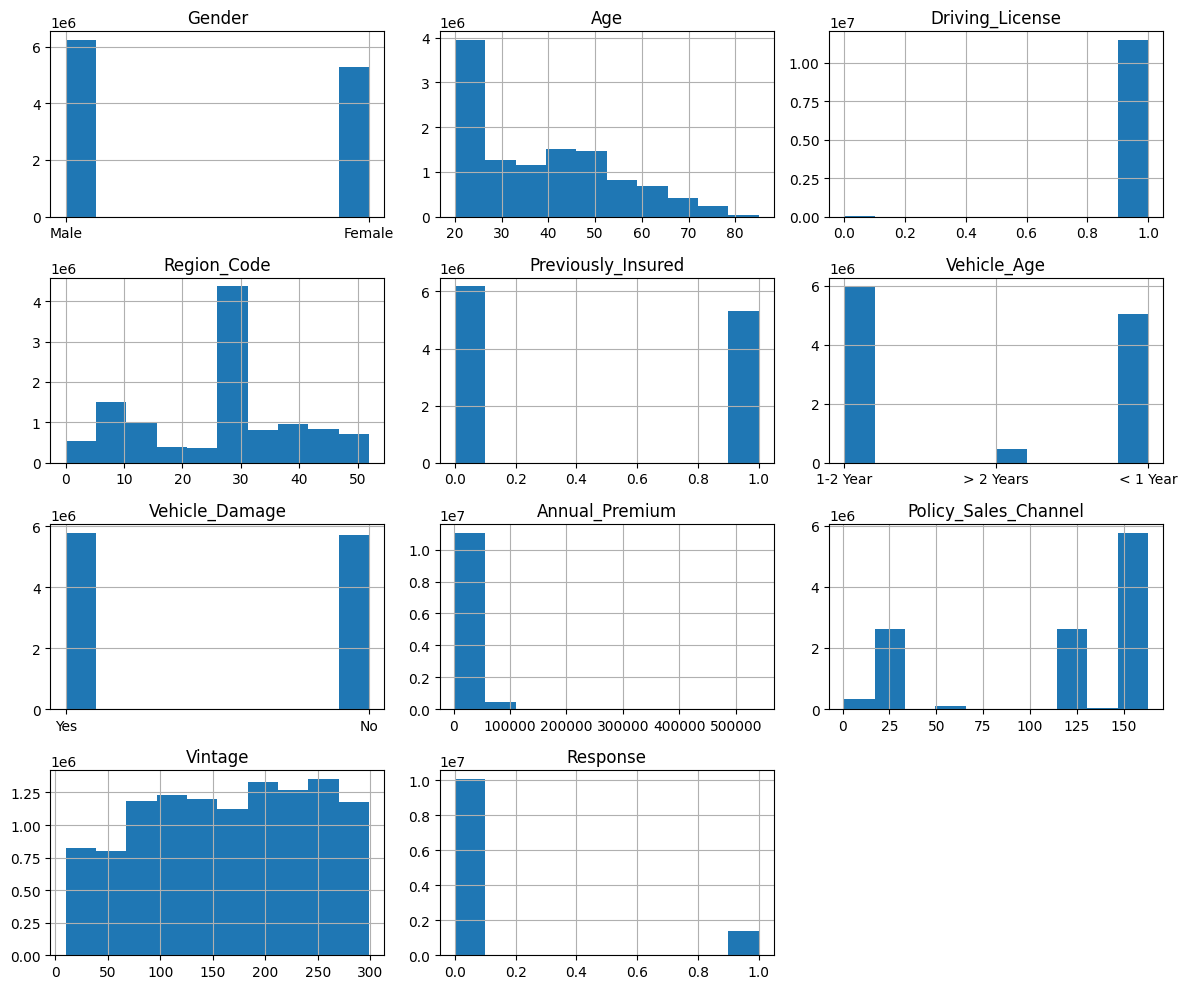

In [8]:
import math

ncows = 3
nrows = math.ceil(df.shape[1] / ncows)

fig, axes = plt.subplots(nrows, ncows, figsize=(12, 10))

for i in range(ncows * nrows):
    ax = axes.flat[i]

    if (i >= df.shape[1]):
        ax.axis('off')
        continue

    col = df.columns[i]
    df[col].hist(ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [9]:
df['Response'].value_counts(normalize=False)

Response
0    10089739
1     1415059
Name: count, dtype: int64

## Model 1

It is a xgbmodel and the data is pre processed without applying SMOTE

### Pre process data 

In [12]:
%%bash
mkdir model2

In [9]:
import pandas as pd
from sklearn.compose import ColumnTransformer as skCT
from sklearn.preprocessing import OrdinalEncoder as skOE
from dask_ml.preprocessing import OrdinalEncoder as dOE, StandardScaler
from dask_ml.compose import ColumnTransformer as dCT
import dask.dataframe as dd

# encode the feature Vehicle_Age in a specific order
va_enc = skCT([
    ('encoder', skOE(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ['Vehicle_Age'])
], remainder='passthrough', verbose_feature_names_out=False)

with pd.read_csv('./train.csv', chunksize=2e6) as reader:
    first = True
    for chunk in reader:
        train_df = chunk.set_index('id')
        X_train_encoded = va_enc.fit_transform(train_df.drop(columns='Response'), train_df['Response'])
        X_train_encoded = pd.DataFrame(X_train_encoded, columns=va_enc.get_feature_names_out(), index=train_df.index)
        train_encoded = X_train_encoded.join(train_df['Response'])
        if first:
            train_encoded.to_csv('./model1/train_partial.csv', index=False)
            first = not first
        else:
            train_encoded.to_csv('./model1/train_partial.csv', mode='a', index=False, header=False)

with pd.read_csv('./test.csv', chunksize=2e6) as reader:
    first = True
    for chunk in reader:
        test_df = chunk.set_index('id')
        test_encoded = va_enc.transform(test_df)
        test_encoded = pd.DataFrame(test_encoded, columns=va_enc.get_feature_names_out(), index=test_df.index)
        if first:
            test_encoded.to_csv('./model1/test_partial.csv')
        else:
            test_encoded.to_csv('./model1/test_partial.csv', mode='a', header=False)

# encode and scale the remain features
train_ddf = dd.read_csv('./model1/train_partial.csv', blocksize=32e6)
train_ddf = train_ddf.categorize()

categorical_cols = list(train_ddf.columns[train_ddf.dtypes == 'category'])
numerical_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
pre_processing = dCT([
    ('categorical_encoder', dOE(), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

processed_cols = pre_processing.fit_transform(train_ddf.drop(columns='Response'), train_ddf['Response'])
categorical_cols.extend(numerical_cols)
train_ddf[categorical_cols] = processed_cols[categorical_cols]
train_ddf.to_csv('./model1/train.csv', single_file=True, index=False, )

test_ddf = dd.read_csv('./model1/test_partial.csv', blocksize=32e6)
test_ddf = test_ddf.set_index('id')
test_ddf = test_ddf.categorize()

categorical_cols = list(test_ddf.columns[test_ddf.dtypes == 'category'])
processed_cols = pre_processing.transform(test_ddf)
categorical_cols.extend(numerical_cols)
test_ddf[categorical_cols] = processed_cols[categorical_cols]
test_ddf.to_csv('./model1/test.csv', single_file=True)

['/home/kenji/kaggle/insurance_cross_selling/model1/test.csv']

In [10]:
%%bash
rm ./model1/train_partial.csv
rm ./model1/test_partial.csv

### Hyperparameter tunning

In [ ]:
import dask.dataframe as dd
import optuna
import xgboost as xgb
from xgboost import dask as dxgb
from dask.distributed import LocalCluster
from dask_ml.model_selection import train_test_split
import numpy as np
RS = 42

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 12),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-9, 1e-3, log=True),
        "alpha": trial.suggest_float("alpha", 1e-9, 1e-3, log=True),
    }

    if (param["booster"] == "gbtree"):
        param["max_depth"] = trial.suggest_int("max_depth", 3, 19)
        param["eta"] = trial.suggest_float("eta", 1e-5, 1, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-5, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if (param["booster"] == "dart"):
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1e-3, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1e-3, log=True)
    
    with LocalCluster() as cluster:
        with cluster.get_client() as client:
            ddf = dd.read_csv('./model1/train.csv', blocksize=16e6)
            X_train, X_val, y_train, y_val = train_test_split(ddf.drop(columns='Response'), ddf['Response'], random_state=RS)
            dtrain = dxgb.DaskDMatrix(client=client, data=X_train, label=y_train)
            dval = dxgb.DaskDMatrix(client, X_val, y_val) 
            bst = dxgb.train(client=client, params=param, dtrain=dtrain, evals=[(dval, 'eval')], verbose_eval=False)
            return np.mean(bst['history']['eval']['auc'])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")

trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

# best params 
# scale_pos_weight: 4.818769375403043
# booster: gbtree
# lambda: 9.380949574651293e-07
# alpha: 4.5611491587845047e-07
# max_depth: 12
# eta: 0.09775875226410187
# gamma: 0.18028557843585707
# grow_policy: lossguide

### Train final model

In [ ]:
import dask.dataframe as dd
from xgboost import dask as dxgb
from dask.distributed import LocalCluster
import pandas as pd
import xgboost as xgb

train_ddf = dd.read_csv('./model1/train.csv', blocksize=8e6)

# put the best parameters found
param = {
    'scale_pos_weight': 4.818769375403043,
    'booster': 'gbtree',
    'lambda': 9.380949574651293e-07,
    'alpha': 4.5611491587845047e-07,
    'max_depth': 12,
    'eta': 0.09775875226410187,
    'gamma': 0.18028557843585707,
    'grow_policy': 'lossguide',
    'verbosity': 0,
    'objective': 'binary:logistic'
}

with LocalCluster() as cluster:
    with cluster.get_client() as client:
        dtrain = dxgb.DaskDMatrix(client, train_ddf.drop(columns='Response'), train_ddf['Response'])
        bst = dxgb.train(client=client, params=param, dtrain=dtrain)
        
        val_ddf = dd.read_csv('./model1/val.csv', blocksize=32e6)
        val_ddf = val_ddf.set_index('id')
        pred = dxgb.predict(client=client, model=bst['booster'], data=val_ddf)
        pred = pred.rename(columns={pred.columns[0]: 'Response'})
        pred.to_csv('./model1/submission.csv', single_file=True)

## Model 2

It is a xgbmodel and the data is pre processed using SMOTE

### Pre process data

In [13]:
%%bash
mkdir model2

In [1]:
from sklearn.compose import ColumnTransformer as skCT
from sklearn.preprocessing import OrdinalEncoder as skOE
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import dask.dataframe as dd
import pandas as pd
from dask_ml.compose import ColumnTransformer as dCT
from dask_ml.preprocessing import StandardScaler 

train_ddf = dd.read_csv('./train.csv', blocksize=1e6)
train_ddf.set_index('id')

categorical_cols = list(train_ddf.columns[train_ddf.dtypes == object])
categorical_cols.remove('Vehicle_Age') # this column will be encoded separately

feature_encoder = skCT([
    ('vehicle_age', skOE(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ['Vehicle_Age']),
    ('categorical', skOE(), categorical_cols)
], remainder='passthrough', verbose_feature_names_out=False)

data_augmentation = Pipeline([
    ('encoder', feature_encoder),
    ('SMOTE', SMOTE())
])

total_rows = len(train_ddf)
chunksize = 1000000
train_chunks = total_rows * 0.9 // chunksize

# encode the features, apply SMOTE and split the training data in training and validation
with pd.read_csv('./train.csv', chunksize=chunksize) as reader:
    num_chunk = 1
    first_train = True
    first_val = True
    for chunk in reader:
        train_df = chunk.set_index('id')

        if (num_chunk <= train_chunks):
            X_balanced_encoded, y_balanced = data_augmentation.fit_resample(train_df.drop(columns='Response'), train_df['Response'])

            X_balanced_encoded = pd.DataFrame(data=X_balanced_encoded, columns=data_augmentation.named_steps['encoder'].get_feature_names_out())
            X_balanced_encoded[X_balanced_encoded.columns] = X_balanced_encoded[X_balanced_encoded.columns].apply(lambda x: round(x))
            X_balanced_encoded[X_balanced_encoded.columns] = X_balanced_encoded[X_balanced_encoded.columns].astype(int)
            train_balanced_encoded = X_balanced_encoded.join(y_balanced)

            train_balanced_encoded = pd.DataFrame(data=shuffle(train_balanced_encoded), columns=train_balanced_encoded.columns)

            if first_train:
                train_balanced_encoded.to_csv('./model2/train_partial.csv', index=False)
                first_train = not first_train
            else:
                train_balanced_encoded.to_csv('./model2/train_partial.csv', index=False, header=False, mode='a')
        
        else:
            X_val_encoded = data_augmentation.named_steps['encoder'].transform(train_df.drop(columns='Response'))
            X_val_encoded = pd.DataFrame(data=X_val_encoded, columns=data_augmentation.named_steps['encoder'].get_feature_names_out(), index=train_df.index)
            val_encoded = X_val_encoded.join(train_df['Response'])

            if first_val:
                val_encoded.to_csv('./model2/val_partial.csv', index=False)
                first_val = not first_val
            else:
                val_encoded.to_csv('./model2/val_partial.csv', index=False, header=False, mode='a')
        
        num_chunk += 1

# scale the data
numerical_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

scaler = dCT([
    ('scaler', StandardScaler(), numerical_cols)
])

train_ddf = dd.read_csv('./model2/train_partial.csv', blocksize=16e6)
scaled_train_features = scaler.fit_transform(train_ddf.drop(columns='Response'), train_ddf['Response'])
train_ddf[numerical_cols] = scaled_train_features[numerical_cols]
train_ddf.to_csv('./model2/train.csv', single_file=True, index=False)

val_ddf = dd.read_csv('./model2/val_partial.csv', blocksize=16e6)
scaled_val_features = scaler.transform(val_ddf.drop(columns='Response'))
val_ddf[numerical_cols] = scaled_val_features[numerical_cols]
val_ddf.to_csv('./model2/val.csv', single_file=True, index=False)

['/home/kenji/kaggle/insurance_cross_selling/model2/val.csv']

In [2]:
%%bash 
rm ./model2/train_partial.csv
rm ./model2/val_partial.csv

### Hyperparameter tunning

In [1]:
import pandas as pd
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 12),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-9, 1e-3, log=True),
        "alpha": trial.suggest_float("alpha", 1e-9, 1e-3, log=True),
    }

    if (param["booster"] == "gbtree"):
        param["max_depth"] = trial.suggest_int("max_depth", 3, 19)
        param["eta"] = trial.suggest_float("eta", 1e-5, 1, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-5, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if (param["booster"] == "dart"):
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1e-3, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1e-3, log=True)

    # training
    with pd.read_csv('./model2/train.csv', chunksize=2000000) as reader:
        first = True
        for chunk in reader:
            dtrain = xgb.DMatrix(chunk.drop(columns='Response'), chunk['Response'])
            if (first):
                bst = xgb.train(params=param, dtrain=dtrain)
                bst.save_model('model.ubj')
                first = not first
            else:
                bst = xgb.train(params=param, dtrain=dtrain, xgb_model='./model.ubj')
                bst.save_model('model.ubj')

    # evaluating
    with pd.read_csv('./model2/val.csv', chunksize=2000000) as reader:
        scores = []
        for chunk in reader:
            bst = xgb.Booster(model_file='model.ubj')
            dval = xgb.DMatrix(chunk.drop(columns='Response'), chunk['Response'])
            y_pred = bst.predict(dval)
            scores.append(roc_auc_score(chunk['Response'], y_pred))

        return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")

trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

# best params 
# scale_pos_weight: 3.747222122421395
# booster: dart
# lambda: 8.95839710667778e-06
# alpha: 9.261783895050363e-05
# sample_type: uniform
# normalize_type: tree
# rate_drop: 3.1381767311567535e-06
# skip_drop: 6.520223621966894e-05

/home/kenji/kaggle/insurance_cross_selling/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kenji/kaggle/insurance_cross_selling/.venv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
[I 2024-07-29 13:03:55,132] A new study created in memory with name: no-name-bbfb012d-

### Train final model

#### Pre process all the training data and test data

In [4]:
%%bash
mkdir model2/submission

In [5]:
from sklearn.compose import ColumnTransformer as skCT
from sklearn.preprocessing import OrdinalEncoder as skOE
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import dask.dataframe as dd
import pandas as pd
from dask_ml.compose import ColumnTransformer as dCT
from dask_ml.preprocessing import StandardScaler 

train_ddf = dd.read_csv('./train.csv', blocksize=1e6)
train_ddf.set_index('id')

categorical_cols = list(train_ddf.columns[train_ddf.dtypes == object])
categorical_cols.remove('Vehicle_Age') # this column will be encoded separately

feature_encoder = skCT([
    ('vehicle_age', skOE(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ['Vehicle_Age']),
    ('categorical', skOE(), categorical_cols)
], remainder='passthrough', verbose_feature_names_out=False)

data_augmentation = Pipeline([
    ('encoder', feature_encoder),
    ('SMOTE', SMOTE())
])

# encode the features and apply SMOTE on the training data
with pd.read_csv('./train.csv', chunksize=1e6) as reader:
    first = True
    for chunk in reader:
        train_df = chunk.set_index('id')
        X_balanced_encoded, y_balanced = data_augmentation.fit_resample(train_df.drop(columns='Response'), train_df['Response'])

        X_balanced_encoded = pd.DataFrame(data=X_balanced_encoded, columns=data_augmentation.named_steps['encoder'].get_feature_names_out())
        X_balanced_encoded[X_balanced_encoded.columns] = X_balanced_encoded[X_balanced_encoded.columns].apply(lambda x: round(x))
        X_balanced_encoded[X_balanced_encoded.columns] = X_balanced_encoded[X_balanced_encoded.columns].astype(int)
        train_balanced_encoded = X_balanced_encoded.join(y_balanced)

        train_balanced_encoded = pd.DataFrame(data=shuffle(train_balanced_encoded), columns=train_balanced_encoded.columns)

        if first:
            train_balanced_encoded.to_csv('./model2/submission/train_partial.csv', index=False)
            first = not first
        else:
            train_balanced_encoded.to_csv('./model2/submission/train_partial.csv', index=False, header=False, mode='a')

# encode the features on the test data  
with pd.read_csv('./test.csv', chunksize=1e6) as reader:
    first = True
    for chunk in reader:
        test_df = chunk.set_index('id')       
        test_encoded = data_augmentation.named_steps['encoder'].transform(test_df)
        test_encoded = pd.DataFrame(data=test_encoded, columns=data_augmentation.named_steps['encoder'].get_feature_names_out(), index=test_df.index)

        if first:
            test_encoded.to_csv('./model2/submission/test_partial.csv')
            first = not first
        else:
            test_encoded.to_csv('./model2/submission/test_partial.csv', header=False, mode='a')

numerical_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

scaler = dCT([
    ('scaler', StandardScaler(), numerical_cols)
])

# scale the training data
train_ddf = dd.read_csv('./model2/submission/train_partial.csv', blocksize=16e6)
scaled_train_features = scaler.fit_transform(train_ddf.drop(columns='Response'), train_ddf['Response'])
train_ddf[numerical_cols] = scaled_train_features[numerical_cols]
train_ddf.to_csv('./model2/submission/train.csv', single_file=True, index=False)

# scale the test data
test_ddf = dd.read_csv('./model2/submission/test_partial.csv', blocksize=16e6)
test_ddf = test_ddf.set_index('id')
scaled_test_features = scaler.transform(test_ddf)
test_ddf[numerical_cols] = scaled_test_features[numerical_cols]
test_ddf.to_csv('./model2/submission/test.csv', single_file=True)

['/home/kenji/kaggle/insurance_cross_selling/model2/submission/test.csv']

In [6]:
%%bash
rm ./model2/submission/train_partial.csv
rm ./model2/submission/test_partial.csv

#### Train the final model

In [2]:
import dask.dataframe as dd
from xgboost import dask as dxgb
from dask.distributed import LocalCluster
import pandas as pd
import xgboost as xgb

# put the best parameters found
param = {
    'scale_pos_weight': 3.747222122421395,
    'booster': 'dart',
    'lambda': 8.95839710667778e-06,
    'alpha': 9.261783895050363e-05,
    'sample_type': 'uniform',
    'normalize_type': 'tree',
    'rate_drop': 3.1381767311567535e-06,
    'skip_drop': 6.520223621966894e-05,
    'verbosity': 0,
    'objective': 'binary:logistic'
}

bst = None
with pd.read_csv('./model2/submission/train.csv', chunksize=2000000) as reader:
    first = True
    for chunk in reader:
        dtrain = xgb.DMatrix(chunk.drop(columns='Response'), chunk['Response'])
        if (first):
            bst = xgb.train(params=param, dtrain=dtrain)
            bst.save_model('./model2/submission/model.ubj')
            first = not first
        else:
            bst = xgb.train(params=param, dtrain=dtrain, xgb_model='./model2/submission/model.ubj')
            bst.save_model('./model2/submission/model.ubj')

with LocalCluster() as cluster:
    with cluster.get_client() as client:
        test_ddf = dd.read_csv('./model2/submission/test.csv', blocksize=32e6)
        test_ddf = test_ddf.set_index('id')
        pred = dxgb.predict(client, bst, test_ddf)
        pred = pred.rename(columns={pred.columns[0]: 'Response'})
        pred.to_csv('./submission/submission.csv', single_file=True)

/home/kenji/kaggle/insurance_cross_selling/.venv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/kenji/kaggle/insurance_cross_selling/.venv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have install